In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
base_folder, thresholds_file = 'results/schaefer400', 'global_metrics.csv'
networks = ['', 'Cont', 'Default', 'DorsAttn', 'SalVentAttn']

In [19]:
def add_curve(thresholds, avg_clustering, lower_error, upper_error, group, ax):
    ax.plot(thresholds, avg_clustering, label=group)
    ax.plot(thresholds, lower_error, alpha=0.1)
    ax.plot(thresholds, upper_error, alpha=0.1)
    ax.legend()
    ax.fill_between(thresholds, lower_error, upper_error, alpha=0.2)

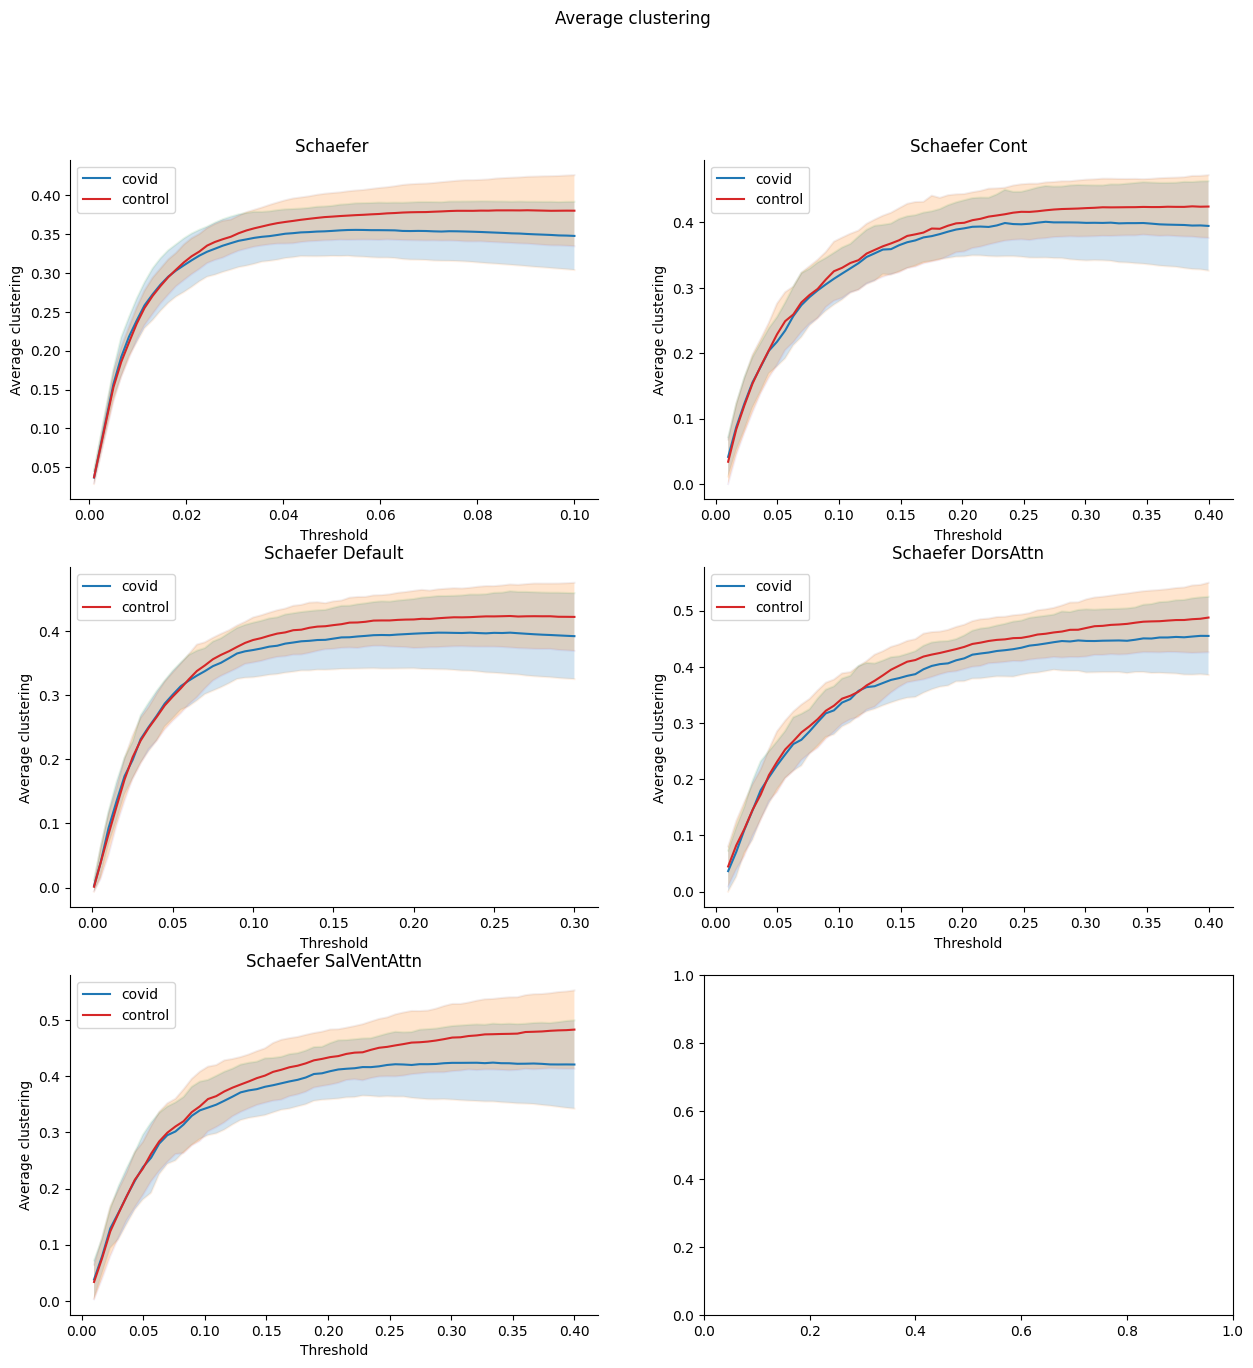

In [25]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=len(networks) // 2 + 1, ncols=2)
for i, network in enumerate(networks):
    network_path = f'{base_folder}_{network}' if network else base_folder
    df = pd.read_csv(Path(network_path, thresholds_file), index_col=0)
    ax = axes[i // 2, i % 2]
    groups = df['group'].unique()
    for group in groups:
        group_metrics = df[df['group'] == group]
        thresholds = group_metrics['threshold'].values
        lower_error, upper_error = group_metrics['avg_clustering'] - group_metrics['avg_clustering_std'], group_metrics['avg_clustering'] + group_metrics['avg_clustering_std']
        avg_clustering = group_metrics['avg_clustering'].values
        add_curve(thresholds, avg_clustering, lower_error, upper_error, group, ax)

    ax.set_title(f'Schaefer {network}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Average clustering')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.suptitle('Average clustering')
fig.savefig('results/schaefer400_avg_clustering.png')
plt.show()